### Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np

from mynn.neural_network import NeuralNetwork
from mynn.layers import Layer
from unsupervised_learning.algorithms import MountainClustering, FuzzCMeans
from anfis.anfis import ANFIS
from anfis.membership.membershipfunction import MemFuncs

from mynn.utils import train_model
from helper_functions.data_management import data_loading, joint_random_sampling
from helper_functions.plotting import plot_training_history, color_plot, plot3d_dataset, plot_embedding

### Auxiliary Functions

In [2]:
def create_autoencoder(num_features: int, num_hidden_units: int, learning_rate: float):

    autoenconder = NeuralNetwork(
        layers=[
            Layer(num_features, num_hidden_units, activation="sigmoid", include_bias=True),
            Layer(num_hidden_units, num_features, activation="sigmoid", include_bias=True),
        ],
        learning_rate=learning_rate,
        loss="cuadratic",
    )

    return autoenconder

def get_autoencoder_embedding(trained_autoencoder: NeuralNetwork, inputs: np.ndarray):

    autoencoder_layers = trained_autoencoder.layers
    encoding_layer = autoencoder_layers[0]

    return encoding_layer.forward(inputs)

def get_mountain_membership_function(centers, destructive_parameter):

    membership_function = []
    for cluster_dimension in centers.T:
        dim_membership_function = []
        for cluster_mean in cluster_dimension:
            dim_membership_function.append(["gaussmf", {"mean": cluster_mean, "sigma": destructive_parameter}])
        membership_function.append(dim_membership_function)

    return membership_function

def get_fuzzy_membership_function(centers, sigmas):

    membership_function = []
    for cluster_dimension in centers.T:
        dim_membership_function = []
        for cluster_num, cluster_mean in enumerate(cluster_dimension):
            dim_membership_function.append(["gaussmf", {"mean": cluster_mean, "sigma": sigmas[cluster_num]}])
        membership_function.append(dim_membership_function)

    return membership_function

### Data loading

In [3]:
manip_category = 'wash_trade'
energy_threshold = 0.5
use_cone = False
root_folder_path = os.path.dirname(os.getcwd())

manip_features = data_loading(root_folder_path, manip_category, energy_threshold, use_cone)

### Visualization

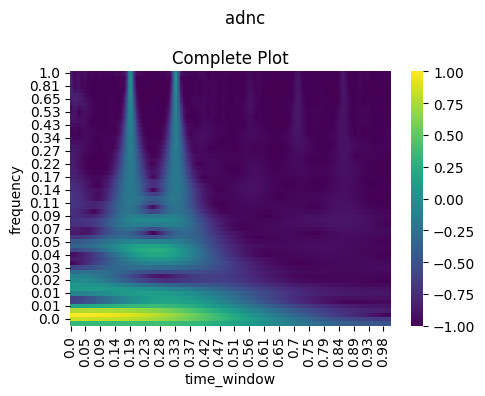

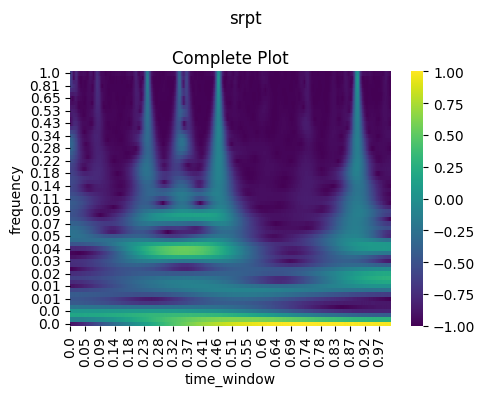

In [4]:
for stock_name, stock_dict in manip_features.items():
    color_plot(stock_dict, stock_name)

### 3d Visualization

In [5]:
stock_name = 'srpt'
plot_against = 'frequency'
hue_var = 'target'
feature_matrix = manip_features[stock_name]['features']

plot3d_dataset(feature_matrix, stock_name, plot_against, hue_var)

### Train autoencoder and get embedding

Epoch 1/3 | Loss: 0.001503670620403398
Epoch 2/3 | Loss: 0.0012881419880628494
Epoch 3/3 | Loss: 0.0012557060106338177


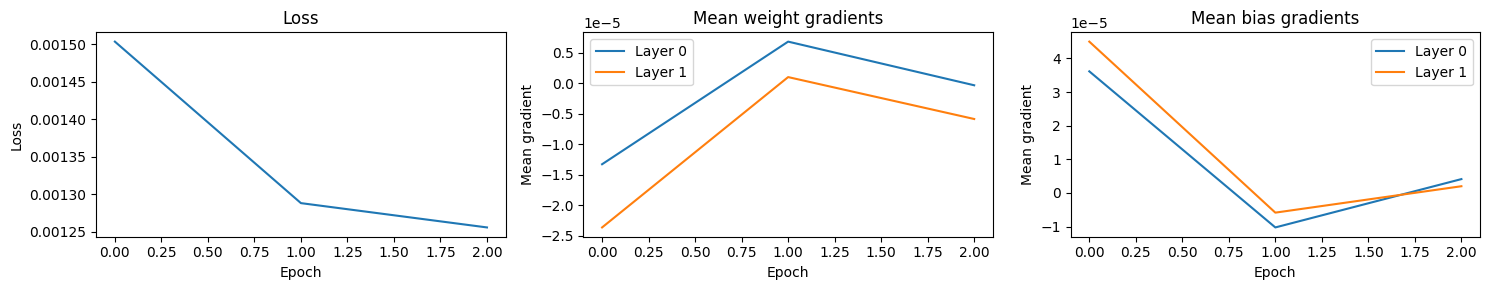

In [79]:
feature_matrices = [
    stock_dict['features'][:, :-2]
    for _, stock_dict in manip_features.items()
]

stacked_feature_matrix = np.vstack(feature_matrices)

autoencoder = create_autoencoder(num_features=stacked_feature_matrix.shape[1], num_hidden_units=2, learning_rate=1)

trained_autoencoder, train_history, _, _ = train_model(
    autoencoder, stacked_feature_matrix, stacked_feature_matrix, num_epochs=3, batch_size=1, verbose=True
)

plot_training_history(train_history, True, stacked_feature_matrix.shape[0])

### Sampling

In [80]:
percentage_to_sample = 5000 / stacked_feature_matrix.shape[0]
train_x_all, train_y, val_x_all, val_y, test_x_all, test_y = joint_random_sampling(manip_features, percentage_to_sample, 0.5, 'uniform', False)

train_x = train_x_all[:, :-1]
train_modulus = train_x_all[:, -1]
val_x = val_x_all[:, :-1]
val_modulus = val_x_all[:, -1]
test_x = test_x_all[:, :-1]
test_modulus = test_x_all[:, -1]

### Plot 3d results of sampled dataset

In [81]:
plot_against = 'frequency'
hue_var = 'modulus'

plot3d_dataset(np.concatenate([train_x_all, train_y.reshape(-1, 1)], axis=1),
                f'{manip_category} - Sampled Dataset',
                plot_against,
                hue_var)

### Get embeddings

In [82]:
train_embedding = get_autoencoder_embedding(trained_autoencoder, train_x.T).T
val_embedding = get_autoencoder_embedding(trained_autoencoder, val_x.T).T
test_embedding = get_autoencoder_embedding(trained_autoencoder, test_x.T).T

### Plot embeddings

In [83]:
plot_embedding(np.hstack([train_embedding, train_modulus.reshape(-1, 1), train_y.reshape(-1, 1)]),
                f'{manip_category} - Embedding Sampled Dataset',
                hue_modulus=True)

### ANFIS

#### Mountain Clustering

In [85]:
sigma_squared = 1.1
beta_squared = sigma_squared*1.5
mountain_clustering = MountainClustering(number_of_partitions=20,
                                        distance_metric='euclidean',
                                        sigma_squared=sigma_squared,
                                        beta_squared=beta_squared,)

mountain_clustering.fit(train_embedding)

MountainClustering(beta_squared=1.6500000000000001, sigma_squared=1.1)

##### ANFIS fitting and prediction

In [89]:
# Get unique centers
fuzzy_centers = np.unique(mountain_clustering.centers_, axis=0)

# Get membership functions
mountain_membership_function = MemFuncs(get_mountain_membership_function(fuzzy_centers, beta_squared))

# Instance anfis object and train it
mountain_anfis = ANFIS(train_embedding, train_modulus, mountain_membership_function)
x_pred = mountain_anfis.trainHybridJangOffLine(epochs=50)

current error: 647.6027138102929
current error: 635.9824633314697
current error: 625.0454312385857
current error: 614.7431570125127
current error: 604.0793351838133
current error: 593.1105909472385
current error: 581.9076802834081
current error: 570.5548040945023
current error: 559.1478214757749
current error: 547.7913596893396
current error: 536.5949712299706
current error: 525.6686305897881
current error: 515.1179625231221
current error: 505.0396277213899
current error: 495.51725520061336
current error: 486.6182148594078
current error: 478.3913921633557
current error: 470.86598618089846
current error: 464.0512244877676


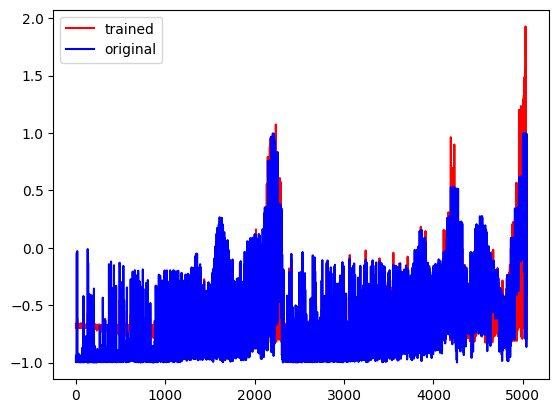

In [90]:
mountain_anfis.plotResults()

#### Fuzzy C Means

In [ ]:
fuzzycmeans = FuzzCMeans(number_of_clusters=4,
                        fuzzines_parameter=2,
                        distance_metric='euclidean',
                        n_iter=1000,
                        verbose=False,)
fuzzycmeans.fit(train_embedding)

sigmas = fuzzycmeans.predict().mean(axis=0).tolist()

In [ ]:
# Get membership functions
mountain_membership_function = MemFuncs(get_mountain_membership_function(fuzzycmeans.centers_, sigmas))

# Instance anfis object and train it
mountain_anfis = ANFIS(train_embedding, train_modulus, mountain_membership_function)
x_pred = mountain_anfis.trainHybridJangOffLine(epochs=50)